# 2つの正規分布の直積モデルのベイズ統計によるWelchのt検定の再現

* 黒木玄
* 2022-09-16, 2022-09-22

2つの正規分布の直積モデルのベイズ統計でWelchのt検定が近似的に再現されることを確認する.

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#μの事後分布の比較" data-toc-modified-id="μの事後分布の比較-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>μの事後分布の比較</a></span><ul class="toc-item"><li><span><a href="#分散が異なる２つの正規分布でデータを生成した場合" data-toc-modified-id="分散が異なる２つの正規分布でデータを生成した場合-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>分散が異なる２つの正規分布でデータを生成した場合</a></span></li><li><span><a href="#異なる２つのガンマ分布でデータを生成した場合" data-toc-modified-id="異なる２つのガンマ分布でデータを生成した場合-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>異なる２つのガンマ分布でデータを生成した場合</a></span></li></ul></li><li><span><a href="#Welchのt検定での自由度の分布" data-toc-modified-id="Welchのt検定での自由度の分布-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Welchのt検定での自由度の分布</a></span><ul class="toc-item"><li><span><a href="#分散が異なる２つの正規分布でデータを生成した場合" data-toc-modified-id="分散が異なる２つの正規分布でデータを生成した場合-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>分散が異なる２つの正規分布でデータを生成した場合</a></span></li><li><span><a href="#異なる２つのガンマ分布でデータを生成した場合" data-toc-modified-id="異なる２つのガンマ分布でデータを生成した場合-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>異なる２つのガンマ分布でデータを生成した場合</a></span></li></ul></li></ul></div>

In [1]:
using Distributions
using QuadGK
using Random
Random.seed!(4649373)
using StatsBase: ecdf
using StatsPlots
default(fmt=:png, titlefontsize=10, plot_titlefontsize=10,
    tickfontsize=6, guidefontsize=9)

distname(dist) = replace(string(dist), r"{[^}]*}"=>"")

distname (generic function with 1 method)

In [2]:
# 通常のWelchのt検定

function tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    (x̄ - ȳ - Δμ) / √(sx²/m + sy²/n)
end

function tvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function degree_of_freedom_welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function degree_of_freedom_welch(x, y)
    m, sx² = length(x), var(x)
    n, sy² = length(y), var(y)
    degree_of_freedom_welch(m, sx², n, sy²)
end

function pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    2ccdf(TDist(ν), abs(t))
end

function pvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_welch(m, x̄, sx², n, ȳ, sy²; α=0.05)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m + sy²/n)
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_welch(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_welch(m, x̄, sx², n, ȳ, sy²; α)
end

confint_welch (generic function with 2 methods)

In [3]:
# Welchのt検定を正確に再現する Δμ に関する分布

function posterior_welch(m, x̄, sx², n, ȳ, sy²)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    SEhat = √(sx²/m + sy²/n)
    x̄ - ȳ + SEhat*TDist(ν)
end

function posterior_welch(x, y)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    posterior_welch(m, x̄, sx², n, ȳ, sy²)
end

posterior_welch (generic function with 2 methods)

次のセルの内容に関する詳しい説明については

* https://github.com/genkuroki/public/blob/main/0036/InverseGammaNormal%20conjugate%20prior%20of%20normal%20distribution.ipynb
* https://github.com/genkuroki/public/blob/main/0036/InverseGammaNormal%20conjugate%20prior%20of%20normal%20distribution.pdf

を参照せよ.

In [4]:
# 1つの正規分布モデルの共役事前分布のベイズ更新

function bayesian_update(μ₀, v₀, κ, θ, n, x̄, σ̂²)
    μ₀_new = (μ₀/v₀ + n*x̄)/(1/v₀ + n)
    v₀_new = 1/(1/v₀ + n)
    κ_new = κ + n/2
    θ_new = θ + (n/2)*(σ̂² + ((x̄ - μ₀)^2/v₀)/(1/v₀ + n))
    μ₀_new, v₀_new, κ_new, θ_new
end

function bayesian_update(μ₀, v₀, κ, θ, y)
    n, ȳ, σ̂² = length(y), mean(y), var(y; corrected=false)
    bayesian_update(μ₀, v₀, κ, θ, n, ȳ, σ̂²)
end

# μに関する周辺事前分布
posterior_μ(μ₀, v₀, κ, θ) = μ₀ + √(θ/κ*v₀)*TDist(2κ)

# x_new に関する事前予測分布
preddist(μ₀, v₀, κ, θ) = μ₀ + √(θ/κ*(1 + v₀))*TDist(2κ)

preddist (generic function with 1 method)

In [5]:
# (μx, μy) に関する事後分布

function posterior_μxμy(m, x̄, σ̂x², n, ȳ, σ̂y²;
        μx₀=0, vx₀=Inf, κx=0, θx=0, μy₀=0, vy₀=Inf, κy=0, θy=0)
    μx₀_new, vx₀_new, κx_new, θx_new = bayesian_update(μx₀, vx₀, κx, θx, m, x̄, σ̂x²)
    μy₀_new, vy₀_new, κy_new, θy_new = bayesian_update(μy₀, vy₀, κy, θy, n, ȳ, σ̂y²)
    posterior_μx = posterior_μ(μx₀_new, vx₀_new, κx_new, θx_new)
    posterior_μy = posterior_μ(μy₀_new, vy₀_new, κy_new, θy_new)
    posterior_μx, posterior_μy
end

function posterior_μxμy(x, y;
        μx₀=0, vx₀=Inf, κx=0, θx=0, μy₀=0, vy₀=Inf, κy=0, θy=0)
    m, x̄, σ̂x² = length(x), mean(x), var(x; corrected=false)
    n, ȳ, σ̂y² = length(y), mean(y), var(y; corrected=false)
    posterior_μxμy(m, x̄, σ̂x², n, ȳ, σ̂y²; μx₀, vx₀, κx, θx, μy₀, vy₀, κy, θy)
end

function rand_posterior_Δμ(x, y; L=10^6,
        μx₀=0, vx₀=Inf, κx=0, θx=0, μy₀=0, vy₀=Inf, κy=0, θy=0)
    posterior_μx, posterior_μy =
        posterior_μxμy(x, y; μx₀, vx₀, κx, θx, μy₀, vy₀, κy, θy)
    [rand(posterior_μx) - rand(posterior_μy) for _ in 1:L]
end

rand_posterior_Δμ (generic function with 1 method)

In [6]:
# X ~ distx, Y ~ disty のときの X - Y が従う分布の密度函数

function pdf_diff(distx, disty, Δ)
    K(y) = pdf(distx, y+Δ) * pdf(disty, y)
    quadgk(K, extrema(disty)...)[1]
end

pdf_diff (generic function with 1 method)

In [7]:
function plot_bayesian_welch(x, y; L=10^6, title="m=$(length(x)), n=$(length(y))")
    posterior_μx, posterior_μy = posterior_μxμy(x, y)
    pdf_Δμ(Δμ) = pdf_diff(posterior_μx, posterior_μy, Δμ)
    post_welch = posterior_welch(x, y)
    xlim = quantile.(post_welch, (0.0001, 0.9999))
    plot(legend=:outertop)
    plot!(pdf_Δμ, xlim...; norm=true, label="posterior of Δμ w.r.t. the flat prior")
    plot!(post_welch, xlim...; label="\"posterior\" reproducing Welch t-test", ls=:dash)
    plot!(xguide="Δμ")
    plot!(; title, xlim)
end

function plot_bayesian_welch(distx, m, disty, n; L=10^6,
        x = rand(distx, m), y = rand(disty, n))
    @show mean(distx) - mean(disty)
    @show var(distx) var(disty)
    @show mean(x) - mean(y)
    @show var(x) var(y)
    @show degree_of_freedom_welch(x, y)
    @show min(m,n) - 1, m + n - 2
    title="$(distname(distx)), m=$m\n$(distname(disty)), n=$n"
    plot_bayesian_welch(x, y; L, title)
end

plot_bayesian_welch (generic function with 2 methods)

## μの事後分布の比較

### 分散が異なる２つの正規分布でデータを生成した場合

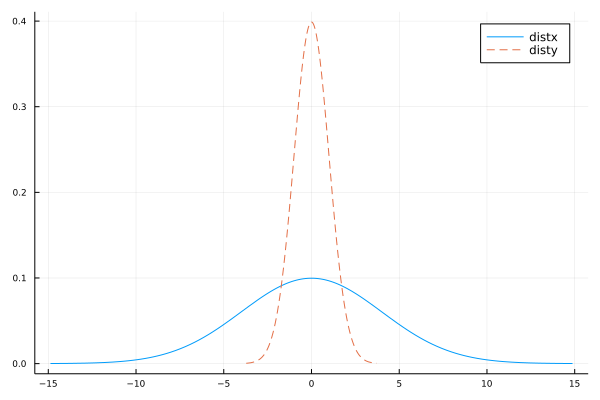

In [8]:
distx = Normal(0, 4)
disty = Normal(0, 1)
plot(distx; label="distx")
plot!(disty; label="disty", ls=:dash)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 0.2141121833156978
var(x) = 17.08082777967237
var(y) = 1.035339903046389
degree_of_freedom_welch(x, y) = 7.845491737127159
(min(m, n) - 1, (m + n) - 2) = (7, 14)


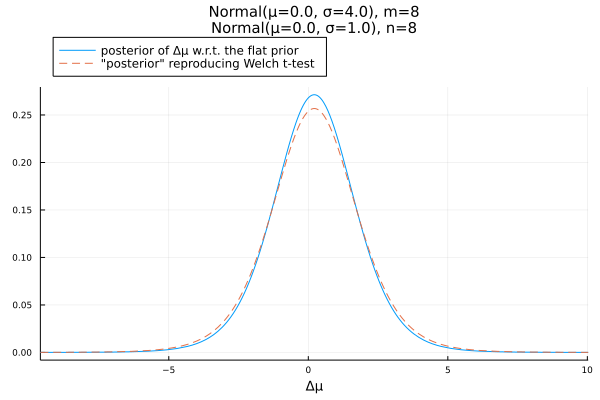

In [9]:
plot_bayesian_welch(distx, 8, disty, 8)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 0.6459718487958624
var(x) = 15.673720237698035
var(y) = 0.904739401426222
degree_of_freedom_welch(x, y) = 10.637775179001364
(min(m, n) - 1, (m + n) - 2) = (5, 14)


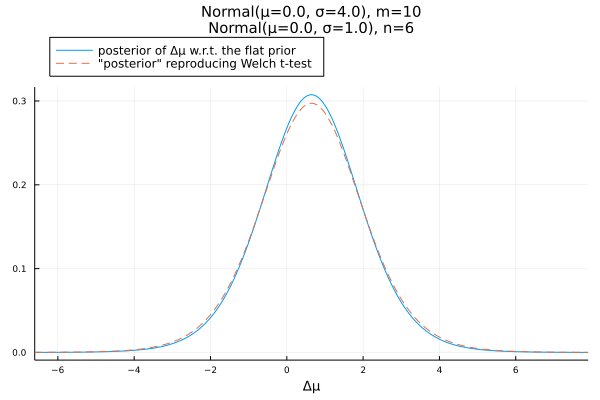

In [10]:
plot_bayesian_welch(distx, 10, disty, 6)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = -1.286925002748466
var(x) = 9.827847484050164
var(y) = 0.8451769124539639
degree_of_freedom_welch(x, y) = 5.521134747067642
(min(m, n) - 1, (m + n) - 2) = (5, 14)


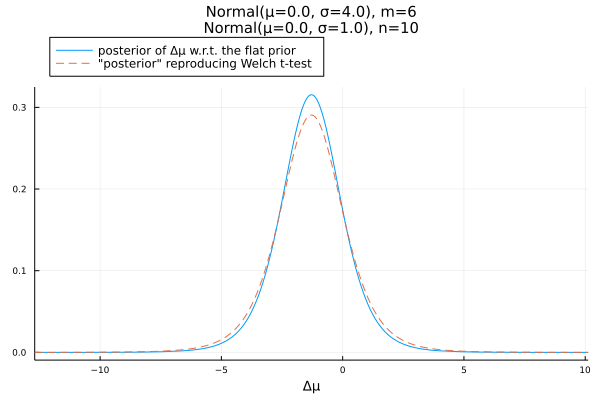

In [11]:
plot_bayesian_welch(distx, 6, disty, 10)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 0.7868680432221338
var(x) = 20.590465973086783
var(y) = 1.2724305307613182
degree_of_freedom_welch(x, y) = 16.846859262141308
(min(m, n) - 1, (m + n) - 2) = (15, 30)


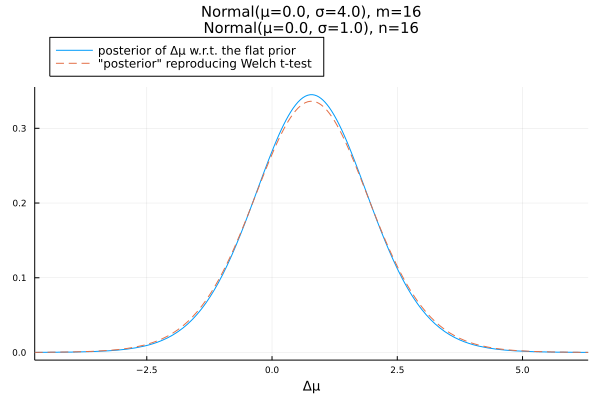

In [12]:
plot_bayesian_welch(distx, 16, disty, 16)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 0.4940704305955499
var(x) = 13.683320451374707
var(y) = 1.4673200911784656
degree_of_freedom_welch(x, y) = 25.01808300788925
(min(m, n) - 1, (m + n) - 2) = (11, 30)


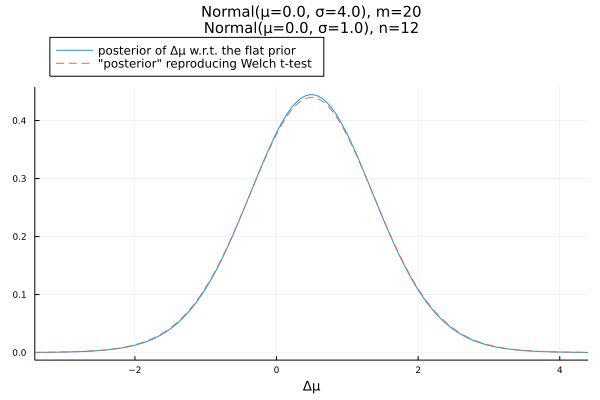

In [13]:
plot_bayesian_welch(distx, 20, disty, 12)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = -1.1255696846198349
var(x) = 9.17145033820437
var(y) = 1.1628134732989048
degree_of_freedom_welch(x, y) = 12.694702769030709
(min(m, n) - 1, (m + n) - 2) = (11, 30)


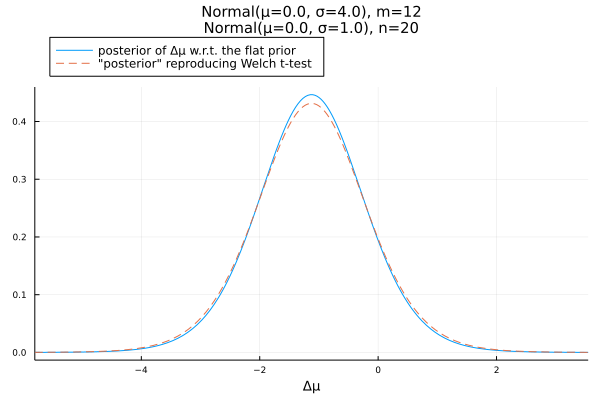

In [14]:
plot_bayesian_welch(distx, 12, disty, 20)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 0.4106264146860263
var(x) = 18.54532153086521
var(y) = 1.2017860663072661
degree_of_freedom_welch(x, y) = 35.00096300729927
(min(m, n) - 1, (m + n) - 2) = (31, 62)


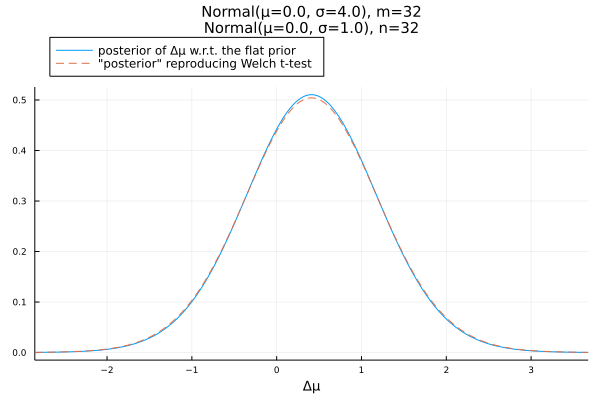

In [15]:
plot_bayesian_welch(distx, 32, disty, 32)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 0.5179242438760969
var(x) = 27.745228980299082
var(y) = 1.7873821364767817
degree_of_freedom_welch(x, y) = 46.907429755662264
(min(m, n) - 1, (m + n) - 2) = (23, 62)


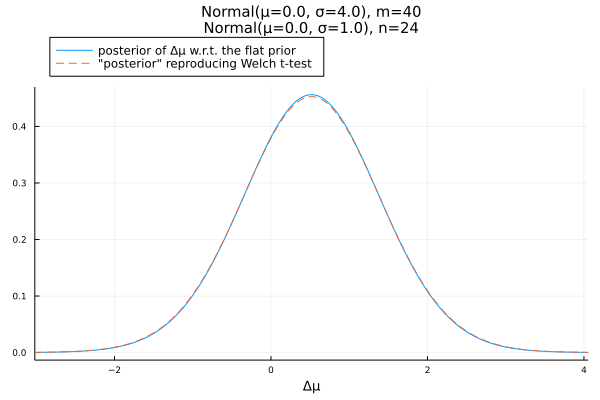

In [16]:
plot_bayesian_welch(distx, 40, disty, 24)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = -0.6033792307599177
var(x) = 18.919078931866814
var(y) = 1.070468674526078
degree_of_freedom_welch(x, y) = 24.571454665029368
(min(m, n) - 1, (m + n) - 2) = (23, 62)


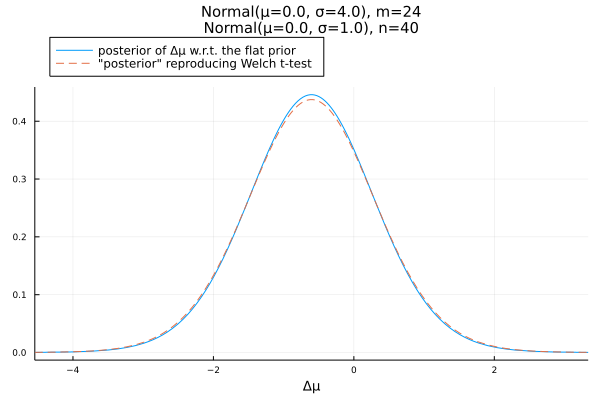

In [17]:
plot_bayesian_welch(distx, 24, disty, 40)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 0.19595793455100413
var(x) = 21.047847675730118
var(y) = 0.917444170022692
degree_of_freedom_welch(x, y) = 68.48173630233454
(min(m, n) - 1, (m + n) - 2) = (63, 126)


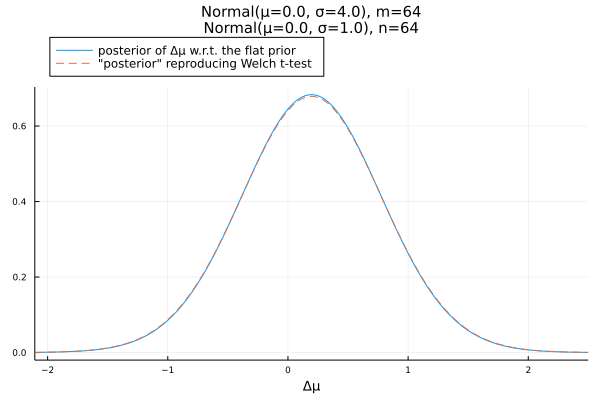

In [18]:
plot_bayesian_welch(distx, 64, disty, 64)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = -0.26870334283473396
var(x) = 12.641921633388323
var(y) = 0.866808599005693
degree_of_freedom_welch(x, y) = 95.98061225649371
(min(m, n) - 1, (m + n) - 2) = (47, 126)


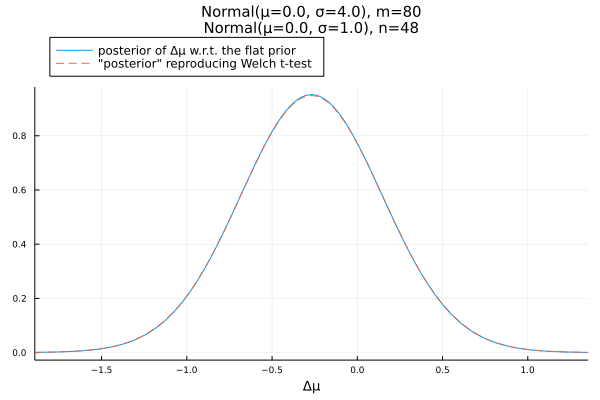

In [19]:
plot_bayesian_welch(distx, 80, disty, 48)

mean(distx) - mean(disty) = 0.0
var(distx) = 16.0
var(disty) = 1.0
mean(x) - mean(y) = 0.8178407727569562
var(x) = 13.106687033556323
var(y) = 0.8464815638652107
degree_of_freedom_welch(x, y) = 50.667845113974714
(min(m, n) - 1, (m + n) - 2) = (47, 126)


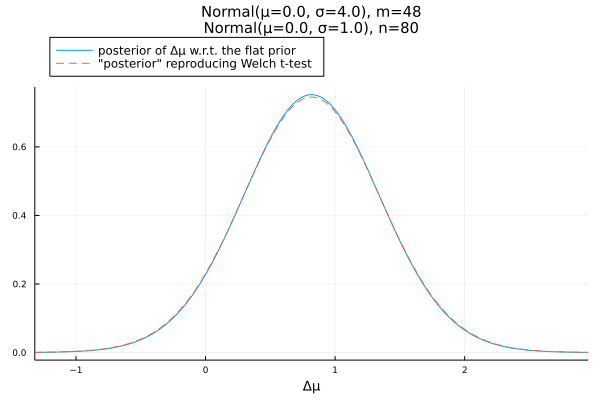

In [20]:
plot_bayesian_welch(distx, 48, disty, 80)

### 異なる２つのガンマ分布でデータを生成した場合

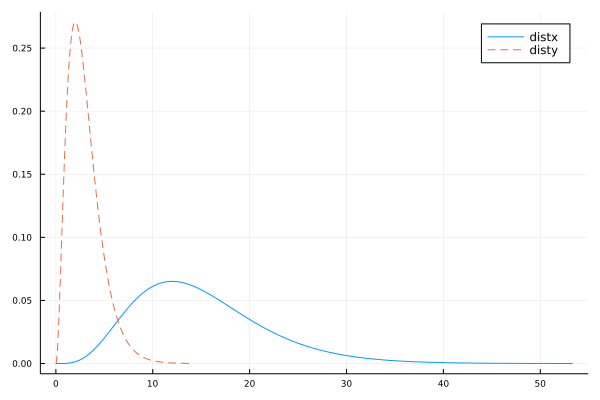

In [21]:
distx = Gamma(5, 3)
disty = Gamma(3, 1)
plot(distx; label="distx")
plot!(disty; label="disty", ls=:dash)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 11.6050569556295
var(x) = 44.86651244311339
var(y) = 1.5933799575055934
degree_of_freedom_welch(x, y) = 7.496566793028047
(min(m, n) - 1, (m + n) - 2) = (7, 14)


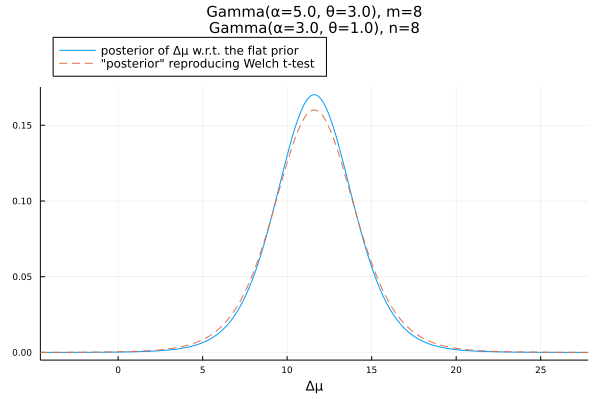

In [22]:
plot_bayesian_welch(distx, 8, disty, 8)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 12.658067547552879
var(x) = 25.68530202249893
var(y) = 5.048671248883281
degree_of_freedom_welch(x, y) = 13.294465200874216
(min(m, n) - 1, (m + n) - 2) = (5, 14)


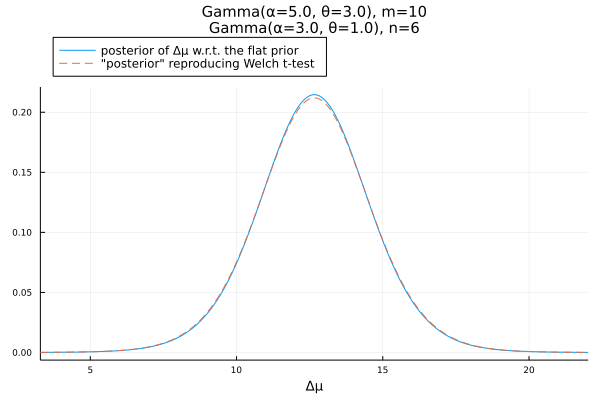

In [23]:
plot_bayesian_welch(distx, 10, disty, 6)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 12.025468961836442
var(x) = 50.24880206144201
var(y) = 4.05125329101881
degree_of_freedom_welch(x, y) = 5.4883086145671465
(min(m, n) - 1, (m + n) - 2) = (5, 14)


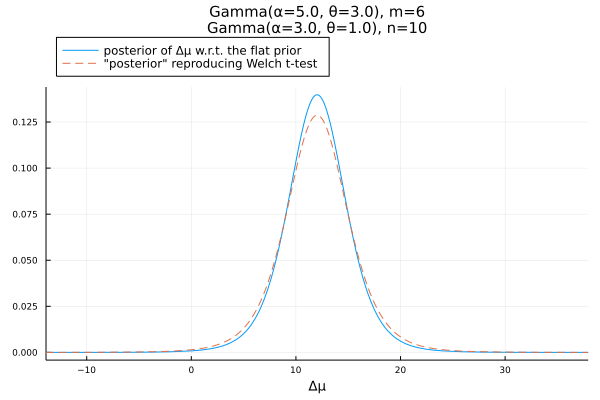

In [24]:
plot_bayesian_welch(distx, 6, disty, 10)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 11.322103188905306
var(x) = 37.36903596525088
var(y) = 3.1653272659957348
degree_of_freedom_welch(x, y) = 17.523033995754894
(min(m, n) - 1, (m + n) - 2) = (15, 30)


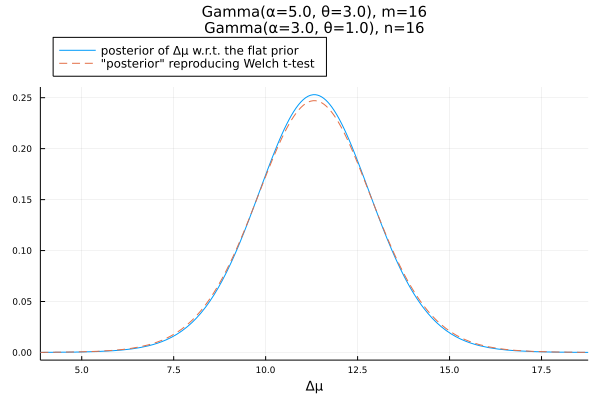

In [25]:
plot_bayesian_welch(distx, 16, disty, 16)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 7.786314560757865
var(x) = 22.777076428715908
var(y) = 3.835960318445735
degree_of_freedom_welch(x, y) = 27.430255826340055
(min(m, n) - 1, (m + n) - 2) = (11, 30)


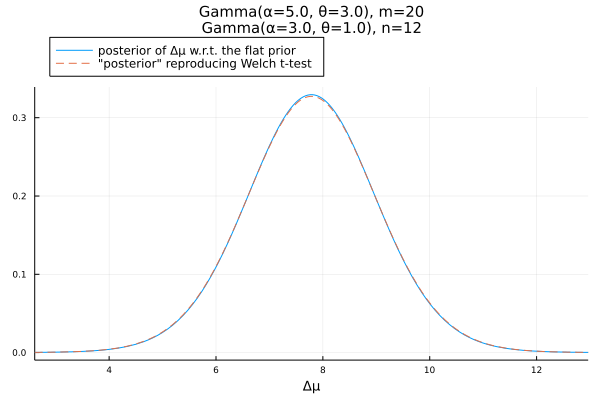

In [26]:
plot_bayesian_welch(distx, 20, disty, 12)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 12.936146657043613
var(x) = 40.23317999470408
var(y) = 3.0053417460375007
degree_of_freedom_welch(x, y) = 11.99416223361011
(min(m, n) - 1, (m + n) - 2) = (11, 30)


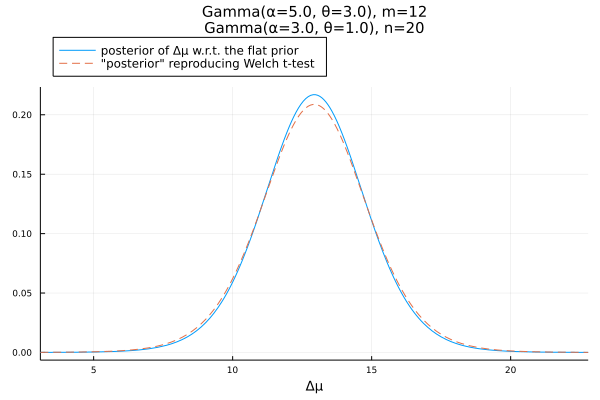

In [27]:
plot_bayesian_welch(distx, 12, disty, 20)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 11.599259323166999
var(x) = 69.61316878755866
var(y) = 3.2964236482718214
degree_of_freedom_welch(x, y) = 33.92934523244739
(min(m, n) - 1, (m + n) - 2) = (31, 62)


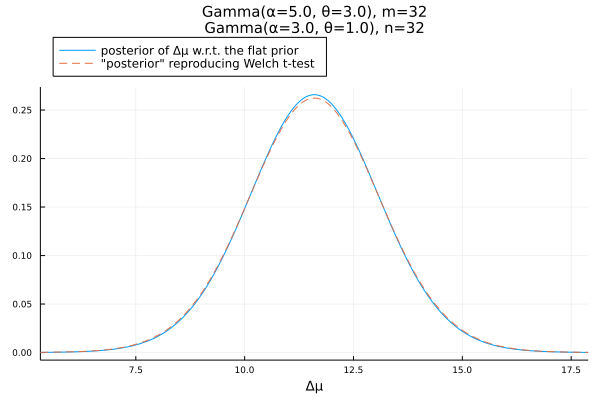

In [28]:
plot_bayesian_welch(distx, 32, disty, 32)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 10.151137710681787
var(x) = 24.353868451895362
var(y) = 2.56857251237554
degree_of_freedom_welch(x, y) = 51.23176330988028
(min(m, n) - 1, (m + n) - 2) = (23, 62)


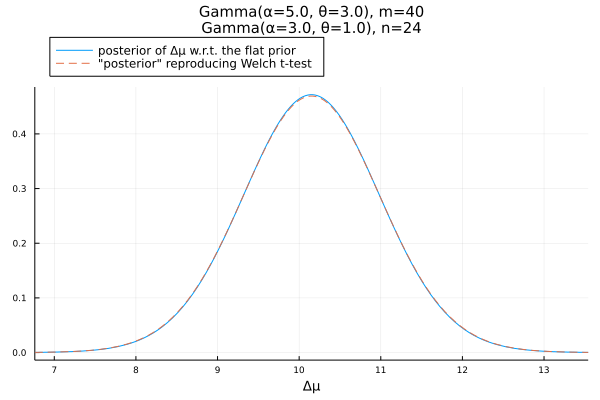

In [29]:
plot_bayesian_welch(distx, 40, disty, 24)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 14.313769782575598
var(x) = 46.47714482243168
var(y) = 2.074873723930279
degree_of_freedom_welch(x, y) = 24.238389590194632
(min(m, n) - 1, (m + n) - 2) = (23, 62)


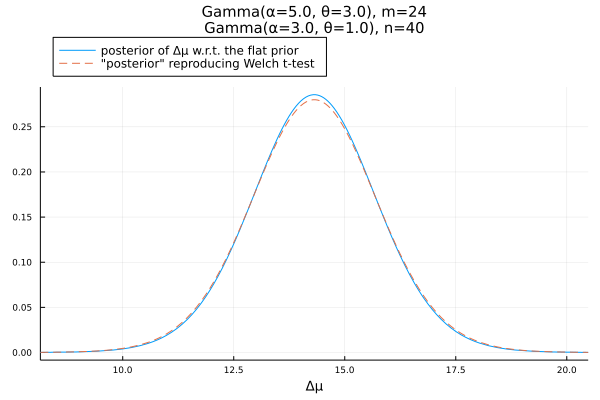

In [30]:
plot_bayesian_welch(distx, 24, disty, 40)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 10.951674516964008
var(x) = 31.996059309428716
var(y) = 2.103253240729577
degree_of_freedom_welch(x, y) = 71.24694407881528
(min(m, n) - 1, (m + n) - 2) = (63, 126)


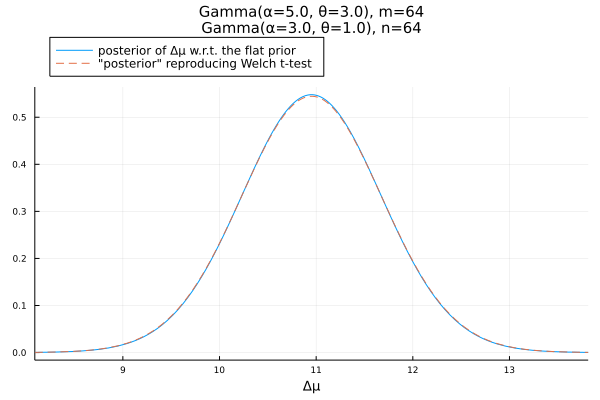

In [31]:
plot_bayesian_welch(distx, 64, disty, 64)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 11.781414580494042
var(x) = 32.436905063345485
var(y) = 1.9728620740851885
degree_of_freedom_welch(x, y) = 94.20108057302565
(min(m, n) - 1, (m + n) - 2) = (47, 126)


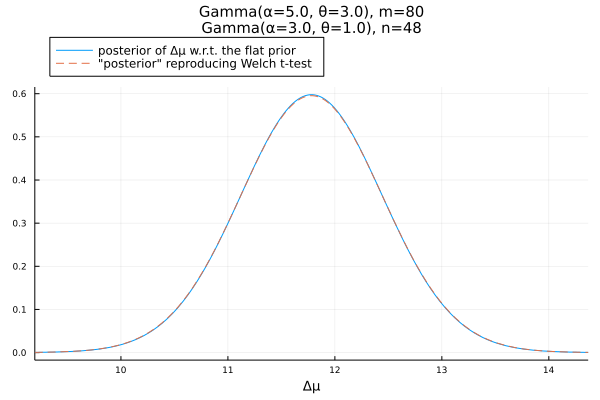

In [32]:
plot_bayesian_welch(distx, 80, disty, 48)

mean(distx) - mean(disty) = 12.0
var(distx) = 45.0
var(disty) = 3.0
mean(x) - mean(y) = 13.265334071100657
var(x) = 32.29897621482283
var(y) = 2.465763846344577
degree_of_freedom_welch(x, y) = 51.34020688422504
(min(m, n) - 1, (m + n) - 2) = (47, 126)


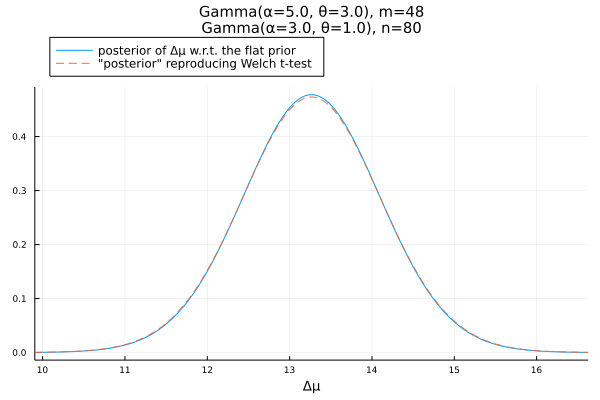

In [33]:
plot_bayesian_welch(distx, 48, disty, 80)

## Welchのt検定での自由度の分布

In [34]:
using Random: rand!

function plot_dist_df_welch(distx, m, disty, n; L=10^6,
        title="m=$m, n=$n", kwargs...)
    tmpx = [Vector{Float64}(undef, m) for _ in 1:Threads.nthreads()]
    tmpy = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    df = Vector{Float64}(undef, L)
    Threads.@threads for i in 1:L
        x = rand!(distx, tmpx[Threads.threadid()])
        y = rand!(distx, tmpy[Threads.threadid()])
        df[i] = degree_of_freedom_welch(x, y)
    end
    
    stephist(df; norm=true, label="")
    plot!(xlim = (min(m,n)-1-0.5, m+n-2+0.5))
    plot!(legend=:topleft)
    title!(title)
    plot!(; kwargs...)
end

function plot_dists_df_welch(distx, disty, mns; L=10^6, kwargs...)
    @assert length(mns) == 9
    PP = []
    for (m, n) in mns
        P = plot_dist_df_welch(distx, m, disty, n; L, kwargs...)
        push!(PP, P)
    end
    plot(PP...; layout=(3, 3), size=(800, 600))
    plot!(plot_title="distributions of df for distx=$(distname(distx)),  disty=$(distname(disty))")
end

plot_dists_df_welch (generic function with 1 method)

### 分散が異なる２つの正規分布でデータを生成した場合

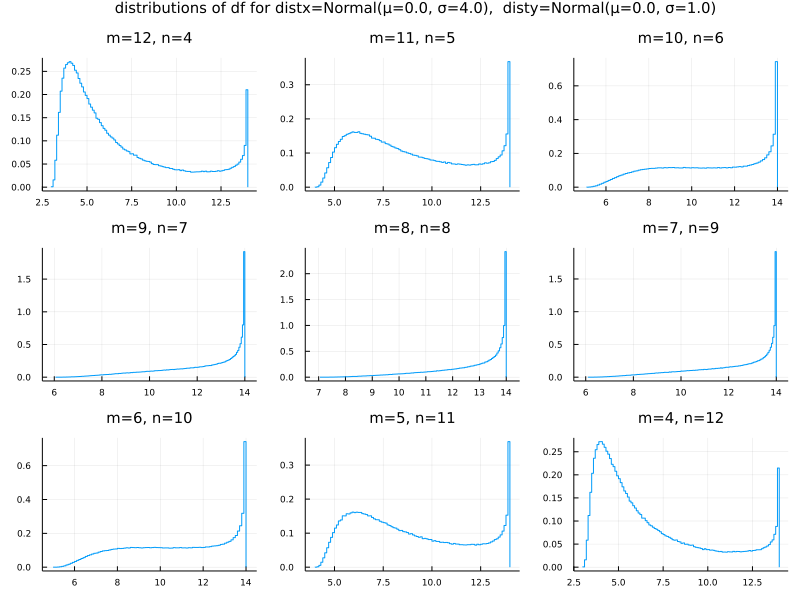

In [35]:
mns = [(8-i, 8+i) for i in -4:4]
plot_dists_df_welch(Normal(0,4), Normal(0,1), mns)

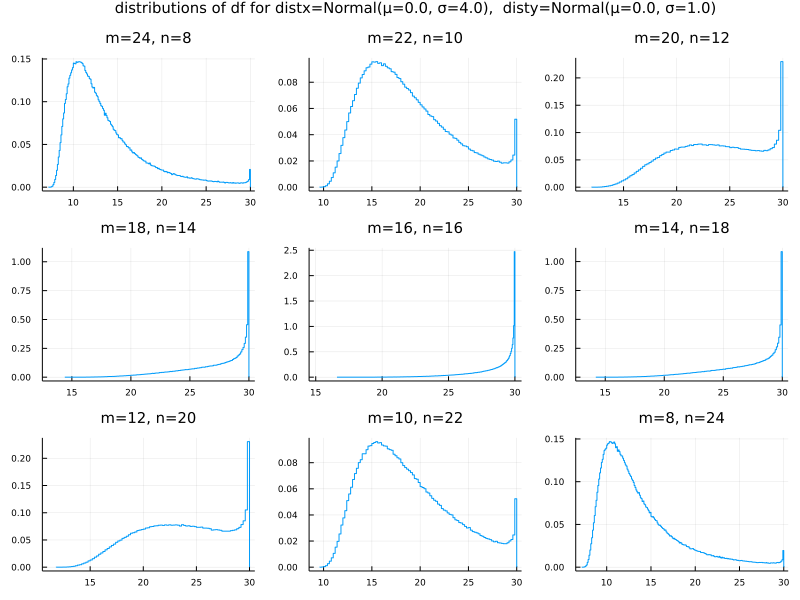

In [36]:
mns = [2 .* (8-i, 8+i) for i in -4:4]
plot_dists_df_welch(Normal(0,4), Normal(0,1), mns)

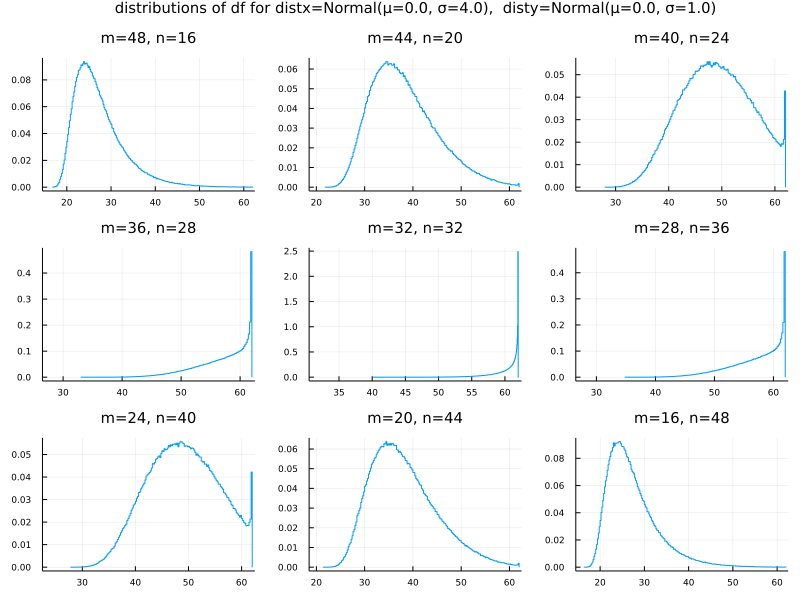

In [37]:
mns = [4 .* (8-i, 8+i) for i in -4:4]
plot_dists_df_welch(Normal(0,4), Normal(0,1), mns)

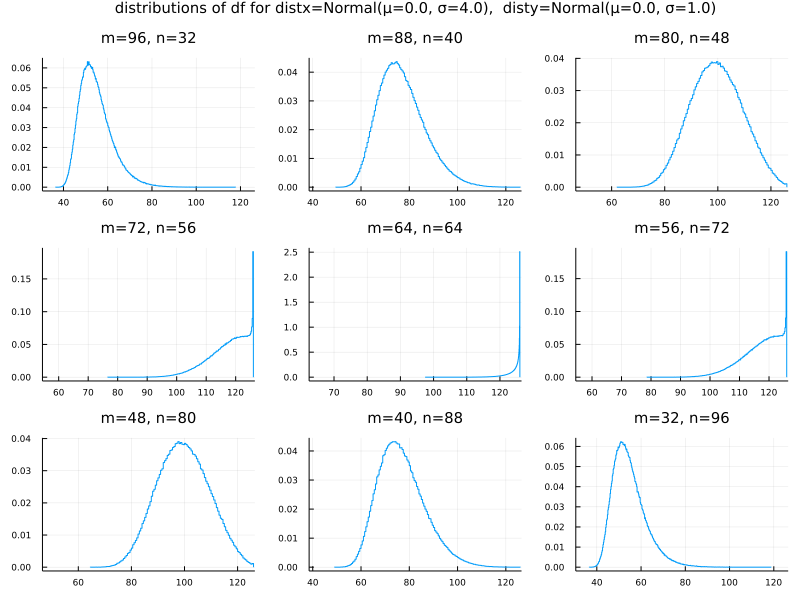

In [38]:
mns = [8 .* (8-i, 8+i) for i in -4:4]
plot_dists_df_welch(Normal(0,4), Normal(0,1), mns)

### 異なる２つのガンマ分布でデータを生成した場合

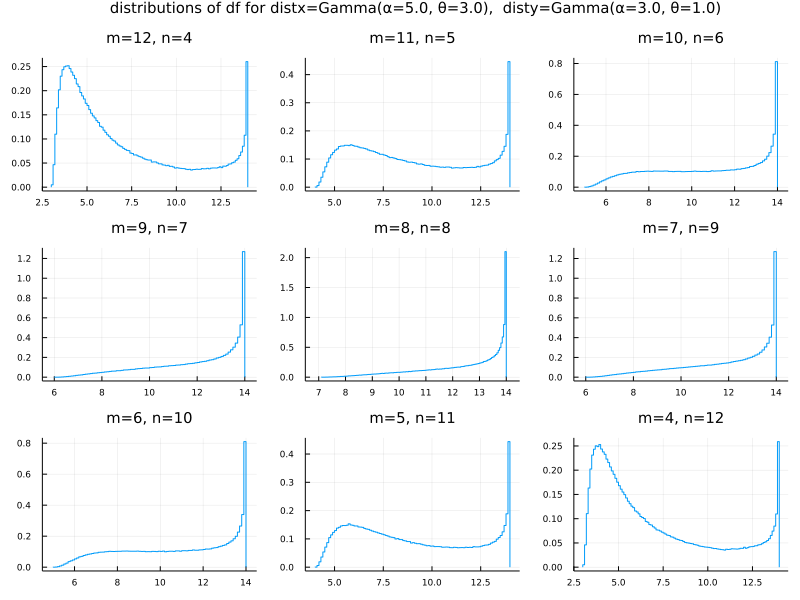

In [39]:
mns = [(8-i, 8+i) for i in -4:4]
plot_dists_df_welch(Gamma(5,3), Gamma(3,1), mns)

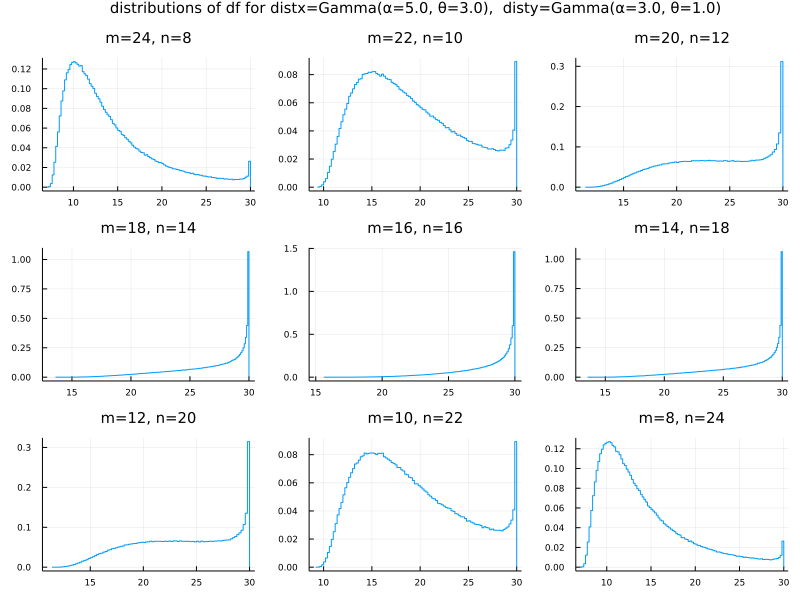

In [40]:
mns = [2 .* (8-i, 8+i) for i in -4:4]
plot_dists_df_welch(Gamma(5,3), Gamma(3,1), mns)

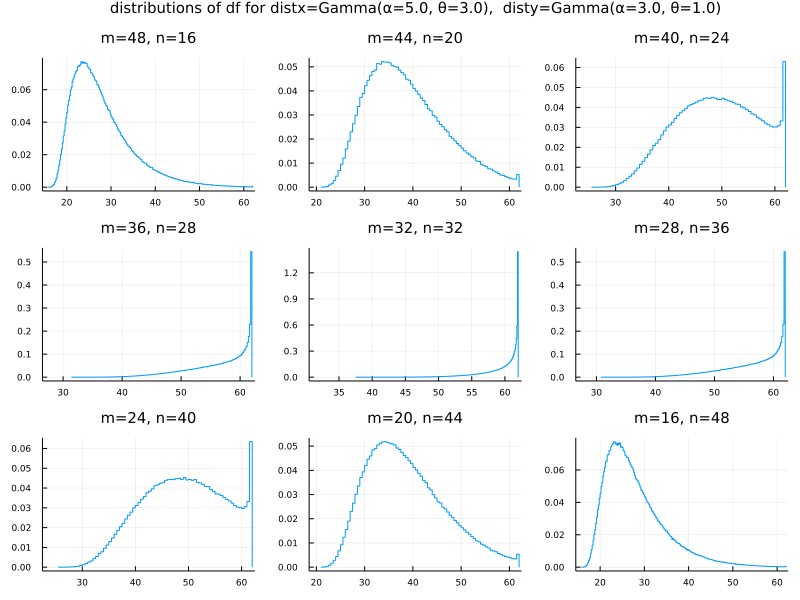

In [41]:
mns = [4 .* (8-i, 8+i) for i in -4:4]
plot_dists_df_welch(Gamma(5,3), Gamma(3,1), mns)

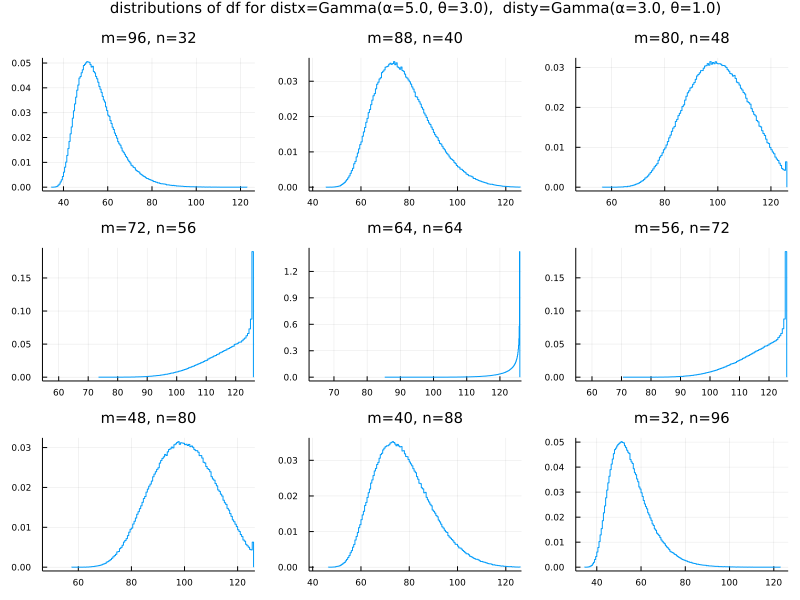

In [42]:
mns = [8 .* (8-i, 8+i) for i in -4:4]
plot_dists_df_welch(Gamma(5,3), Gamma(3,1), mns)